In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer
import re
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle
from sklearn.metrics import roc_auc_score
from tqdm import tqdm
import os
#from plotly import plotly
#import plotly.offline as offline
#import plotly.graph_objs as go
#offline.init_notebook_mode()
from collections import Counter
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation,Flatten,Reshape
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import LSTM
from tensorflow.keras.preprocessing.text import Tokenizer
import csv
from tensorflow.keras.models import Model
#import keras
from tensorflow.keras import backend as k
from tensorflow.keras.layers import Input,Concatenate,Dropout,Dense,BatchNormalization,Conv1D
from tensorflow.keras.layers import Input
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
#from tensorflow.keras.merge import concatenate
#import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
import scipy
from tensorflow.keras.initializers import he_normal,glorot_normal
from tensorflow.keras.regularizers import l1,l2
from tensorflow.python.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import Callback, EarlyStopping, ModelCheckpoint,LearningRateScheduler,ReduceLROnPlateau
from time import time
from tensorflow.keras.utils import plot_model

In [ ]:
import pandas as pd
from pandas import DataFrame
train = pd.read_csv("/content/gdrive/MyDrive/mercari/train.tsv", sep="\t")
test=pd.read_csv('/content/gdrive/MyDrive/mercari/test_stg2.tsv',sep="\t")

In [ ]:
train.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity


In [ ]:
train.isnull().sum()

train_id                  0
name                      0
item_condition_id         0
category_name          6327
brand_name           632682
price                     0
shipping                  0
item_description          4
dtype: int64

In [ ]:
test.isnull().sum()

test_id                    0
name                       0
item_condition_id          0
category_name          14833
brand_name           1476490
shipping                   0
item_description           6
dtype: int64

In [ ]:
category_split_arr = []
def category_split(category_name):
    try:
        val1,val2,val3=category_name.split('/')
        return val1,val2,val3
    except:
        return ('Missing', 'Missing', 'Missing')

In [ ]:
train['main_category'], train['sub_category'], train['item_category'] =zip(*train['category_name'].apply(lambda x: category_split(x)))

In [ ]:
test['main_category'], test['sub_category'], test['item_category'] =zip(*test['category_name'].apply(lambda x: category_split(x)))

In [ ]:
# Drop category_name feature
train=train.drop(['category_name'],axis=1)
test=test.drop(["category_name"],axis=1)

In [ ]:
train=train[(train['price']>3) & (train['price']<2000)]

In [ ]:
train['brand_name'] = train['brand_name'].fillna(value='other_null')
test['brand_name'] = test['brand_name'].fillna(value='other_null')

In [ ]:
train['item_description'] = train['item_description'].fillna(value='no_description_yet')
test['item_description'] = test['item_description'].fillna(value='no_description_yet')

In [ ]:
# Remove Emoji
def deEmojify(text):
    regrex_pattern = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags = re.UNICODE)
    return regrex_pattern.sub(r'',text)
def decontractions(phrase):
    """decontracted takes text and convert contractions into natural form.
     ref: https://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python/47091490#47091490"""
    # specific
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)
    phrase = re.sub(r"won\’t", "will not", phrase)
    phrase = re.sub(r"can\’t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)

    phrase = re.sub(r"n\’t", " not", phrase)
    phrase = re.sub(r"\’re", " are", phrase)
    phrase = re.sub(r"\’s", " is", phrase)
    phrase = re.sub(r"\’d", " would", phrase)
    phrase = re.sub(r"\’ll", " will", phrase)
    phrase = re.sub(r"\’t", " not", phrase)
    phrase = re.sub(r"\’ve", " have", phrase)
    phrase = re.sub(r"\’m", " am", phrase)

    return phrase

In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
from nltk.corpus import stopwords
from tqdm import tqdm
import re
stopwords = stopwords.words('english')
def preprocess(text_col,stopword):
    preprocessed = []
    for sentence in tqdm(text_col.values):
        # Replace "carriage return" with "space".
        sentence=str(sentence)
        sent = sentence.replace('\\r', ' ')
        # Replace "quotes" with "space".
        sent = sent.replace('\\"', ' ')
        # Replace "line feed" with "space".
        sent = sent.replace('\\n', ' ')
        # Replace characters between words with "space".
        sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
        #remove stop words
        #decontraction
        sent=decontractions(sent)
        #Remove emoji
        sent=deEmojify(sent)
        if stopword:
            sent = ' '.join(e for e in sent.split() if e not in stopwords)
        # to lowercase
        preprocessed.append(sent.lower().strip())
    return preprocessed

In [ ]:
# Preprocessing on item_description train data.
train['item_description'] = preprocess(train['item_description'],stopword=True)

100%|██████████| 1462949/1462949 [02:33<00:00, 9512.81it/s]


In [ ]:
# Preprocessing on item_description test data.
test['item_description'] = preprocess(test['item_description'],stopword=True)

100%|██████████| 3460725/3460725 [05:52<00:00, 9804.88it/s]


In [ ]:
train['name'] = preprocess(train['name'],stopword=False)

100%|██████████| 1462949/1462949 [00:40<00:00, 36301.49it/s]


In [ ]:
test['name'] = preprocess(test['name'],stopword=False)

100%|██████████| 3460725/3460725 [01:33<00:00, 36980.05it/s]


In [ ]:
import numpy as np
train['log_price'] = np.log1p(train['price'])

In [ ]:
train['name']=train['name']+" "+train['brand_name']+" "+train['main_category']+" "+train['item_category']+" "+train['sub_category']
test['name']=test['name']+" "+test['brand_name']+" "+test['main_category']+" "+test['item_category']+" "+test['sub_category']

In [ ]:
from sklearn.model_selection import train_test_split
df_train,df_test=train_test_split(train,test_size=0.33,random_state=42)

In [ ]:
def pad_text(text,tokenizer,max_len):
    return pad_sequences(tokenizer.texts_to_sequences(text),maxlen=max_len,padding='post')

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
def text_padding(train,test,test_final,max_len):
    token=Tokenizer()
    token.fit_on_texts(train)
    padded_train_text=pad_text(train,token,max_len)
    padded_test_text=pad_text(test,token,max_len)
    padded_test_final_text=pad_text(test_final,token,max_len)
    return padded_train_text,padded_test_text,padded_test_final_text,token

In [ ]:
Name_len=300
train_name_pad,test_name_pad,test_name_final_pad,token_name= text_padding(df_train['name'].values,df_test['name'].values,test['name'].values,Name_len)

In [ ]:
print(train_name_pad.shape,test_name_pad.shape,test_name_final_pad.shape)

(980175, 300) (482774, 300) (3460725, 300)


In [ ]:
item_len=300
train_desc_pad,test_desc_pad,test_final_desc_pad,token_desc = text_padding(df_train['item_description'],df_test['item_description'],test['item_description'],item_len)

In [ ]:
print(train_desc_pad.shape,test_desc_pad.shape,test_final_desc_pad.shape)

(980175, 300) (482774, 300) (3460725, 300)


In [ ]:
def generate_embedding_matrix(token):
    embedding_path='/content/gdrive/MyDrive/crawl-300d-2M.vec'
    embedding_size=300
    vocab_size=5000
    embedding_index={}
    with open(embedding_path, 'r') as f:
         for line in f:
             values = line.rstrip().rsplit(' ')
             word = values[0]
             coefs = np.asarray(values[1:], dtype='float32')
             embedding_index[word] = coefs
    num_words = len(token.word_index) + 1
    embedding_matrix = np.zeros((num_words, embedding_size))
    for word, i in token.word_index.items():
       embedding_vector = embedding_index.get(word)
       if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
          embedding_matrix[i] = embedding_vector
    return embedding_matrix

In [ ]:
embedding_name = generate_embedding_matrix(token_name)
embedding_desc = generate_embedding_matrix(token_desc)
print(embedding_name.shape,embedding_desc.shape)

(83905, 300) (129242, 300)


In [ ]:
ship_train=df_train['shipping'].values.reshape(-1,1)
ship_test=df_test['shipping'].values.reshape(-1,1)
ship_final=test['shipping'].values.reshape(-1,1)

In [ ]:
item_cond_train=df_train['item_condition_id'].values.reshape(-1,1)
item_cond_test=df_test['item_condition_id'].values.reshape(-1,1)
item_cond_final=test['item_condition_id'].values.reshape(-1,1)

In [ ]:
print('#Numerical data-----')
numerical_train=np.concatenate((ship_train,item_cond_train),axis=1)
numerical_test=np.concatenate((ship_test,item_cond_test),axis=-1)
numerical_final=np.concatenate((ship_final,item_cond_final),axis=1)
print(numerical_train.shape,numerical_test.shape,numerical_final.shape)

#Numerical data-----
(980175, 2) (482774, 2) (3460725, 2)


In [ ]:
y_train=df_train['log_price'].values
y_test=df_test['log_price'].values

In [ ]:
X_train=(train_name_pad,train_desc_pad,numerical_train)
X_test=(test_name_pad,test_desc_pad,numerical_test)
test_f=[test_name_final_pad,test_final_desc_pad,numerical_final]

In [ ]:
del train
del test

In [ ]:
from tensorflow.keras.layers import concatenate
def LSTM_Model(Name_len,token_name,embedding_name,item_len,token_desc,embedding_desc):
    drop_lstm = 0.25
    drop_dense = 0.25
    num_lstm=150
    input_text_1=Input(shape=(Name_len,), name='NAME', dtype='float32')
    sequence_input_1=Embedding(len(token_name.word_index) + 1,300,weights=[embedding_name],input_length=Name_len,trainable=False)(input_text_1)
    sequence_input_1=LSTM(num_lstm,dropout=drop_lstm,return_sequences=True)(sequence_input_1)
    sequence_input_1=Flatten()(sequence_input_1)
    input_text_2=Input(shape=(item_len,),name='Item_desc', dtype='float32')
    sequence_input_2=Embedding(len(token_desc.word_index) + 1,300,weights=[embedding_desc],input_length=item_len,trainable=False)(input_text_2)
    sequence_input_2=LSTM(num_lstm,dropout=drop_lstm,return_sequences=True)(sequence_input_2)
    sequence_input_2=Flatten()(sequence_input_2)
    input5 = Input(shape=(2,),name='Numerical', dtype='float32')
    flatten_6 = Dense(32,activation='relu',kernel_initializer=he_normal(),kernel_regularizer=l2(0.0001))(input5)
    flatten_6 = Dense(16,activation='relu',kernel_initializer=he_normal(),kernel_regularizer=l2(0.0001))(flatten_6)
    concat=concatenate([sequence_input_1,sequence_input_2,flatten_6])
    y = Dense(128,activation='relu',kernel_initializer=he_normal(),kernel_regularizer=l2(0.01))(concat)
    y = BatchNormalization()(y)
    y = Dense(64,activation='relu',kernel_initializer=he_normal(),kernel_regularizer=l2(0.01))(y)
    y = BatchNormalization()(y)
    y = Dense(32,activation='relu',kernel_initializer=he_normal(),kernel_regularizer=l2(0.01))(y)
    final_output = Dense(1)(y)
    model= Model(inputs=[input_text_1,input_text_2,input5],outputs=[final_output])
    return model

In [ ]:
model=LSTM_Model(Name_len,token_name,embedding_name,item_len,token_desc,embedding_desc)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
NAME (InputLayer)               [(None, 300)]        0                                            
__________________________________________________________________________________________________
Item_desc (InputLayer)          [(None, 300)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 300, 300)     25171500    NAME[0][0]                       
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 300, 300)     38772600    Item_desc[0][0]                  
______________________________________________________________________________________________

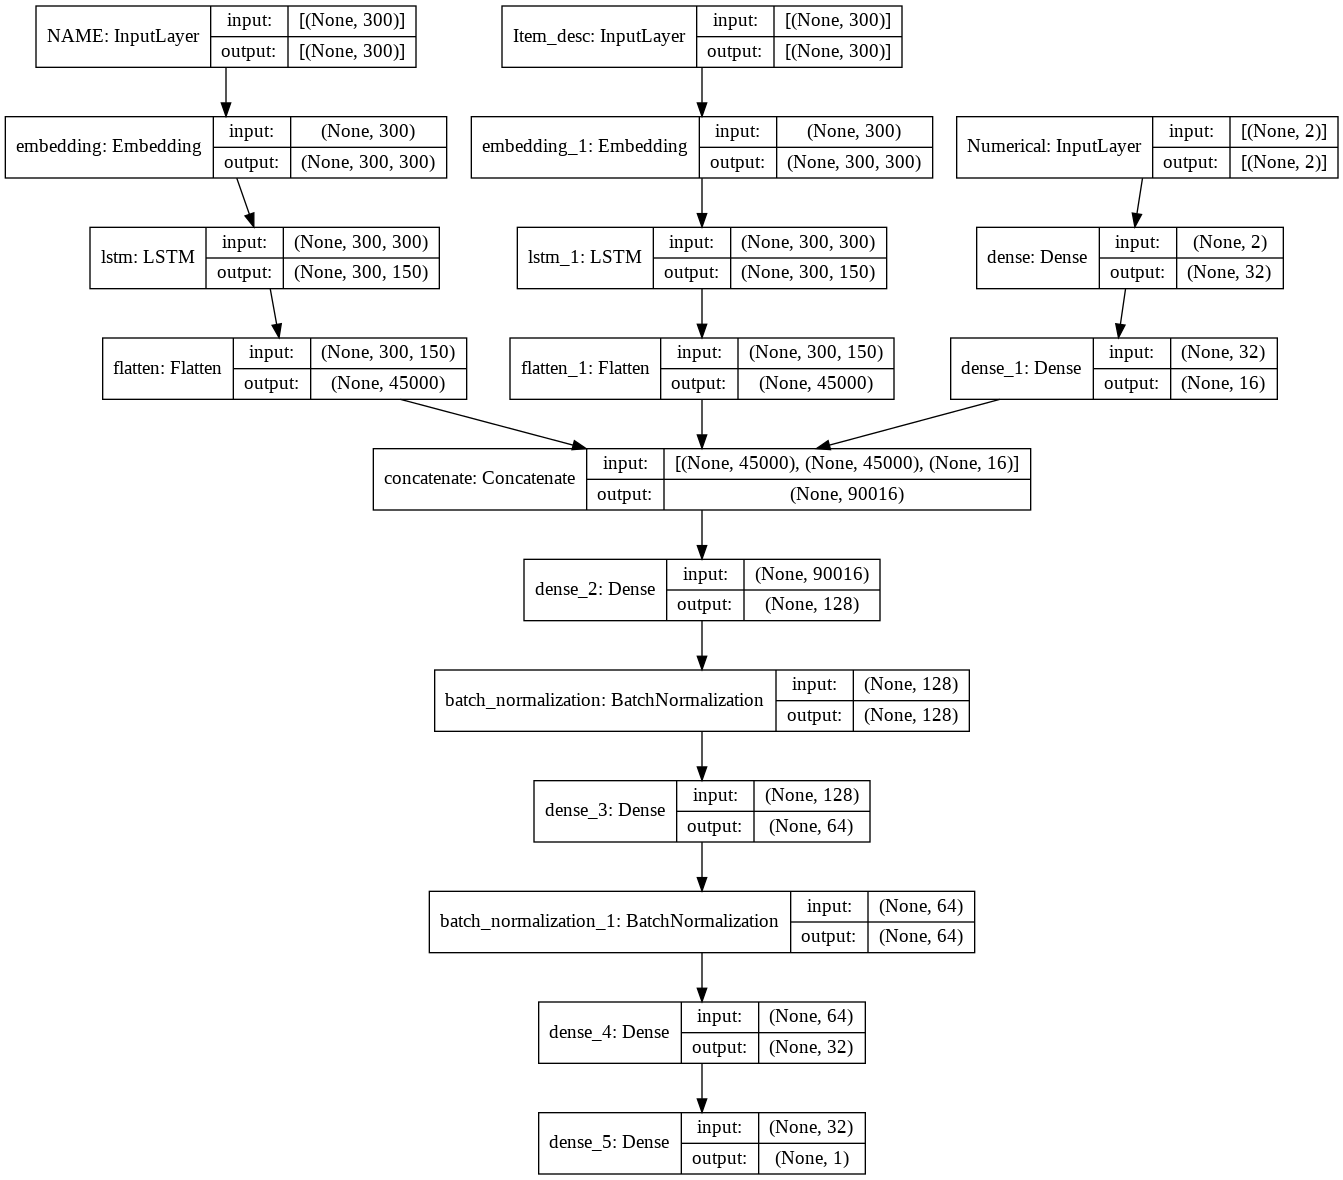

In [ ]:
plot_model(model, to_file='model_1.png', show_shapes=True, show_layer_names=True)

In [ ]:
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras import backend as K

def root_mean_squared_log_error(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

In [ ]:
from keras import optimizers

optimizer =tf.keras.optimizers.Adam()
model.compile(optimizer='adam',loss='mean_squared_error',metrics=[tf.keras.metrics.RootMeanSquaredError(),root_mean_squared_log_error])

In [ ]:
from tensorflow.keras.callbacks import *
filepath="weights_1.best.hdf1"
checkpoint = ModelCheckpoint(filepath, monitor='val_root_mean_squared_log_error', verbose=1, mode='min')
earlystop = EarlyStopping(monitor = 'val_root_mean_squared_log_error',  mode="min",min_delta = 0, patience = 3,verbose = 1)
#reduce_lr = ReduceLROnPlateau(monitor = 'val_root_mean_squared_log_error', factor = 0.2, patience = 2, verbose = 1)
%reload_ext tensorboard
import datetime
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
#tensorboard = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
tensorboard = TensorBoard(log_dir=logdir, histogram_freq=0, write_graph=True, write_grads=False, write_images=False)
callbacks = [checkpoint,tensorboard]

In [ ]:
history_1 =model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=20,verbose=1,callbacks=callbacks,batch_size=512)

Epoch 1/20
1915/1915 [==============================] - 372s 194ms/step - loss: 0.1640 - root_mean_squared_error: 0.3979 - root_mean_squared_log_error: 0.3976 - val_loss: 0.6991 - val_root_mean_squared_error: 0.8330 - val_root_mean_squared_log_error: 0.8329

Epoch 00001: saving model to weights_1.best.hdf1


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


Epoch 2/20
1915/1915 [==============================] - 369s 193ms/step - loss: 0.1626 - root_mean_squared_error: 0.3963 - root_mean_squared_log_error: 0.3959 - val_loss: 0.2000 - val_root_mean_squared_error: 0.4411 - val_root_mean_squared_log_error: 0.4407

Epoch 00002: saving model to weights_1.best.hdf1


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


Epoch 3/20
1915/1915 [==============================] - 370s 193ms/step - loss: 0.1613 - root_mean_squared_error: 0.3950 - root_mean_squared_log_error: 0.3947 - val_loss: 0.6167 - val_root_mean_squared_error: 0.7822 - val_root_mean_squared_log_error: 0.7820

Epoch 00003: saving model to weights_1.best.hdf1


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


Epoch 4/20
1915/1915 [==============================] - 370s 193ms/step - loss: 0.1607 - root_mean_squared_error: 0.3938 - root_mean_squared_log_error: 0.3935 - val_loss: 0.1925 - val_root_mean_squared_error: 0.4322 - val_root_mean_squared_log_error: 0.4317

Epoch 00004: saving model to weights_1.best.hdf1


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


Epoch 5/20
1915/1915 [==============================] - 370s 193ms/step - loss: 0.1586 - root_mean_squared_error: 0.3918 - root_mean_squared_log_error: 0.3915 - val_loss: 1.0019 - val_root_mean_squared_error: 0.9984 - val_root_mean_squared_log_error: 0.9981

Epoch 00005: saving model to weights_1.best.hdf1


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


Epoch 6/20
1915/1915 [==============================] - 370s 193ms/step - loss: 0.1585 - root_mean_squared_error: 0.3911 - root_mean_squared_log_error: 0.3907 - val_loss: 0.1940 - val_root_mean_squared_error: 0.4349 - val_root_mean_squared_log_error: 0.4344

Epoch 00006: saving model to weights_1.best.hdf1


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets



Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Epoch 7/20
1915/1915 [==============================] - 371s 194ms/step - loss: 0.1500 - root_mean_squared_error: 0.3838 - root_mean_squared_log_error: 0.3835 - val_loss: 0.1823 - val_root_mean_squared_error: 0.4239 - val_root_mean_squared_log_error: 0.4235

Epoch 00007: saving model to weights_1.best.hdf1


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


Epoch 8/20
1915/1915 [==============================] - 370s 193ms/step - loss: 0.1491 - root_mean_squared_error: 0.3829 - root_mean_squared_log_error: 0.3825 - val_loss: 0.2429 - val_root_mean_squared_error: 0.4904 - val_root_mean_squared_log_error: 0.4901

Epoch 00008: saving model to weights_1.best.hdf1


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


Epoch 9/20
1915/1915 [==============================] - 369s 193ms/step - loss: 0.1483 - root_mean_squared_error: 0.3818 - root_mean_squared_log_error: 0.3815 - val_loss: 0.3216 - val_root_mean_squared_error: 0.5649 - val_root_mean_squared_log_error: 0.5646

Epoch 00009: saving model to weights_1.best.hdf1


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets



Epoch 00009: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
Epoch 10/20
1915/1915 [==============================] - 370s 193ms/step - loss: 0.1459 - root_mean_squared_error: 0.3796 - root_mean_squared_log_error: 0.3793 - val_loss: 0.1831 - val_root_mean_squared_error: 0.4260 - val_root_mean_squared_log_error: 0.4255

Epoch 00010: saving model to weights_1.best.hdf1


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


Epoch 11/20
1915/1915 [==============================] - 368s 192ms/step - loss: 0.1451 - root_mean_squared_error: 0.3789 - root_mean_squared_log_error: 0.3786 - val_loss: 0.1873 - val_root_mean_squared_error: 0.4311 - val_root_mean_squared_log_error: 0.4306

Epoch 00011: saving model to weights_1.best.hdf1


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets



Epoch 00011: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.
Epoch 12/20
1915/1915 [==============================] - 370s 193ms/step - loss: 0.1442 - root_mean_squared_error: 0.3778 - root_mean_squared_log_error: 0.3775 - val_loss: 0.1798 - val_root_mean_squared_error: 0.4225 - val_root_mean_squared_log_error: 0.4220

Epoch 00012: saving model to weights_1.best.hdf1


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


Epoch 13/20
1915/1915 [==============================] - 370s 193ms/step - loss: 0.1442 - root_mean_squared_error: 0.3780 - root_mean_squared_log_error: 0.3777 - val_loss: 0.1761 - val_root_mean_squared_error: 0.4181 - val_root_mean_squared_log_error: 0.4176

Epoch 00013: saving model to weights_1.best.hdf1


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


Epoch 14/20
1915/1915 [==============================] - 370s 193ms/step - loss: 0.1441 - root_mean_squared_error: 0.3779 - root_mean_squared_log_error: 0.3776 - val_loss: 0.1908 - val_root_mean_squared_error: 0.4353 - val_root_mean_squared_log_error: 0.4348

Epoch 00014: saving model to weights_1.best.hdf1


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


Epoch 15/20
1915/1915 [==============================] - 370s 193ms/step - loss: 0.1438 - root_mean_squared_error: 0.3776 - root_mean_squared_log_error: 0.3773 - val_loss: 0.1755 - val_root_mean_squared_error: 0.4174 - val_root_mean_squared_log_error: 0.4169

Epoch 00015: saving model to weights_1.best.hdf1


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


Epoch 16/20
1915/1915 [==============================] - 368s 192ms/step - loss: 0.1439 - root_mean_squared_error: 0.3777 - root_mean_squared_log_error: 0.3774 - val_loss: 0.1753 - val_root_mean_squared_error: 0.4173 - val_root_mean_squared_log_error: 0.4168

Epoch 00016: saving model to weights_1.best.hdf1


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


Epoch 17/20
1915/1915 [==============================] - 368s 192ms/step - loss: 0.1436 - root_mean_squared_error: 0.3773 - root_mean_squared_log_error: 0.3770 - val_loss: 0.1901 - val_root_mean_squared_error: 0.4346 - val_root_mean_squared_log_error: 0.4342

Epoch 00017: saving model to weights_1.best.hdf1


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


Epoch 18/20
1915/1915 [==============================] - 368s 192ms/step - loss: 0.1437 - root_mean_squared_error: 0.3775 - root_mean_squared_log_error: 0.3771 - val_loss: 0.1793 - val_root_mean_squared_error: 0.4221 - val_root_mean_squared_log_error: 0.4216

Epoch 00018: saving model to weights_1.best.hdf1


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets



Epoch 00018: ReduceLROnPlateau reducing learning rate to 3.906250185536919e-06.
Epoch 19/20
1915/1915 [==============================] - 368s 192ms/step - loss: 0.1433 - root_mean_squared_error: 0.3770 - root_mean_squared_log_error: 0.3766 - val_loss: 0.1780 - val_root_mean_squared_error: 0.4205 - val_root_mean_squared_log_error: 0.4200

Epoch 00019: saving model to weights_1.best.hdf1


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


Epoch 20/20
1915/1915 [==============================] - 368s 192ms/step - loss: 0.1434 - root_mean_squared_error: 0.3771 - root_mean_squared_log_error: 0.3768 - val_loss: 0.1753 - val_root_mean_squared_error: 0.4173 - val_root_mean_squared_log_error: 0.4168

Epoch 00020: saving model to weights_1.best.hdf1


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets



Epoch 00020: ReduceLROnPlateau reducing learning rate to 9.765625463842298e-07.


In [ ]:
model_1_pred=model.predict(test_f)

In [ ]:
submission=pd.read_csv('/content/gdrive/MyDrive/mercari/sample_submission_stg2.csv')
submission.head()

,test_id,price
0,0,26.738
1,1,26.738
2,2,26.738
3,3,26.738
4,4,26.738


In [ ]:
final_pred_1=np.expm1(model_1_pred)

In [ ]:
submission['price']=final_pred_1
submission.to_csv('/content/gdrive/MyDrive/mercari/DL_2_submission.csv',index=False)

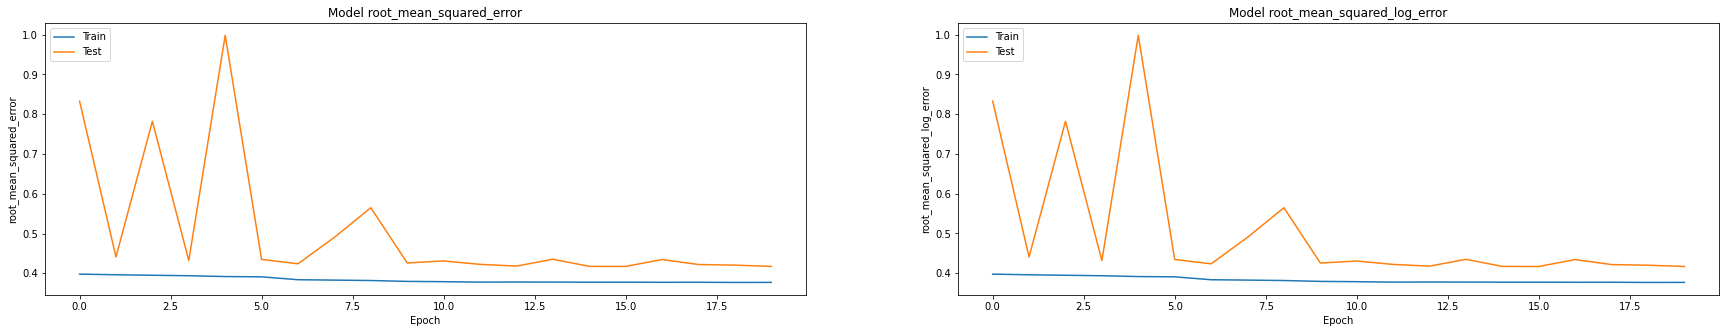

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(30, 5))
plt.subplot(121)
plt.plot(history_1.history['root_mean_squared_error'])
plt.plot(history_1.history['val_root_mean_squared_error'])
plt.title('Model root_mean_squared_error')
plt.ylabel('root_mean_squared_error')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation f1_score
plt.subplot(122)
plt.plot(history_1.history['root_mean_squared_log_error'])
plt.plot(history_1.history['val_root_mean_squared_log_error'])
plt.title('Model root_mean_squared_log_error')
plt.ylabel('root_mean_squared_log_error')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
import scipy
from tensorflow.keras.initializers import he_normal,glorot_normal
from tensorflow.keras.regularizers import l1,l2
from tensorflow.python.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import Callback, EarlyStopping, ModelCheckpoint,LearningRateScheduler,ReduceLROnPlateau
from time import time
from tensorflow.keras.utils import plot_model
from sklearn.metrics import roc_auc_score
import tensorflow as tf
from tensorflow.keras.callbacks import Callback 
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dense,Input,Activation,BatchNormalization,Dropout
from tensorflow.keras.models import Model
from tensorflow.keras import optimizers
import random as rn
import string
from sklearn.metrics import f1_score
from tensorflow import keras
import tensorflow as tf
import numpy as np
import datetime
import os
import math
import pandas as pd
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.initializers import glorot_uniform,glorot_normal
from tensorflow.keras.layers import MaxPooling1D

In [ ]:
def Deep_CNN1D2(Name_len,token_name,embedding_name,item_len,token_desc,embedding_desc):
    drop_lstm = 0.25
    drop_dense = 0.25
    num_lstm=150
    input_1 = Input(shape=(Name_len,),name = 'Name_comment')
    embedding_layer_1 = Embedding(len(token_name.word_index) + 1,300,weights=[embedding_name],input_length=Name_len,trainable=False,dtype=tf.float32)(input_1)
    conv_1_1 = Conv1D(32,3,strides=1, padding='same',activation='relu')(embedding_layer_1)
    lstm_1_1 = LSTM(32,dropout=drop_lstm,return_sequences=True,dtype=tf.float32)(embedding_layer_1)
    concate_1 = tf.keras.layers.Concatenate(axis=-1)([conv_1_1, lstm_1_1])
    flatten_1 = Flatten()(concate_1)

    # creating layers for parent comment data
    input_2 = Input(shape=(item_len,),name = 'Desc_comment')
    embedding_layer_2 = Embedding(len(token_desc.word_index) + 1,300,weights=[embedding_desc],input_length=item_len,trainable=False,dtype=tf.float32)(input_2)
    conv_1_1 = Conv1D(32,3,strides=1, padding='same',activation='relu')(embedding_layer_2)
    lstm_1_2 =LSTM(32,dropout=drop_lstm,return_sequences=True,dtype=tf.float32)(embedding_layer_2)
    concate_2 = tf.keras.layers.Concatenate(axis=-1)([conv_1_1, lstm_1_2])
    flatten_2 = Flatten()(concate_2)

    # creating layers for numerical columns
    input_3 = Input(shape=(2,), name = "input_numerical")
    dense_num_layer = Dense(128, activation = "relu")(input_3)

    concatenated_layer = tf.keras.layers.concatenate([flatten_1,flatten_2,dense_num_layer],axis=-1)

    # creating further layers
    x = Dense(128, activation = 'relu',kernel_initializer=glorot_uniform(seed=42))(concatenated_layer)
    x = BatchNormalization()(x)
    x = Dense(64, activation = 'relu',kernel_initializer=glorot_uniform(seed=42))(x)
    x = BatchNormalization()(x)
    x = Dense(32, activation = 'relu',kernel_initializer=glorot_uniform(seed=42))(x)
    x = BatchNormalization()(x)
    x = Dense(16, activation = 'relu',kernel_initializer=glorot_uniform(seed=42))(x)
    final_output = Dense(1)(x)
    model = Model(inputs = [input_1,input_2,input_3], outputs = [final_output])
    return model

In [ ]:
model1=Deep_CNN1D2(Name_len,token_name,embedding_name,item_len,token_desc,embedding_desc)
model1.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Name_comment (InputLayer)       [(None, 300)]        0                                            
__________________________________________________________________________________________________
Desc_comment (InputLayer)       [(None, 300)]        0                                            
__________________________________________________________________________________________________
embedding_11 (Embedding)        (None, 300, 300)     25171500    Name_comment[0][0]               
__________________________________________________________________________________________________
embedding_12 (Embedding)        (None, 300, 300)     38772600    Desc_comment[0][0]               
____________________________________________________________________________________________

In [ ]:
model1.compile(optimizer='adam', loss='mean_squared_error',metrics=[tf.keras.metrics.RootMeanSquaredError(),root_mean_squared_log_error])

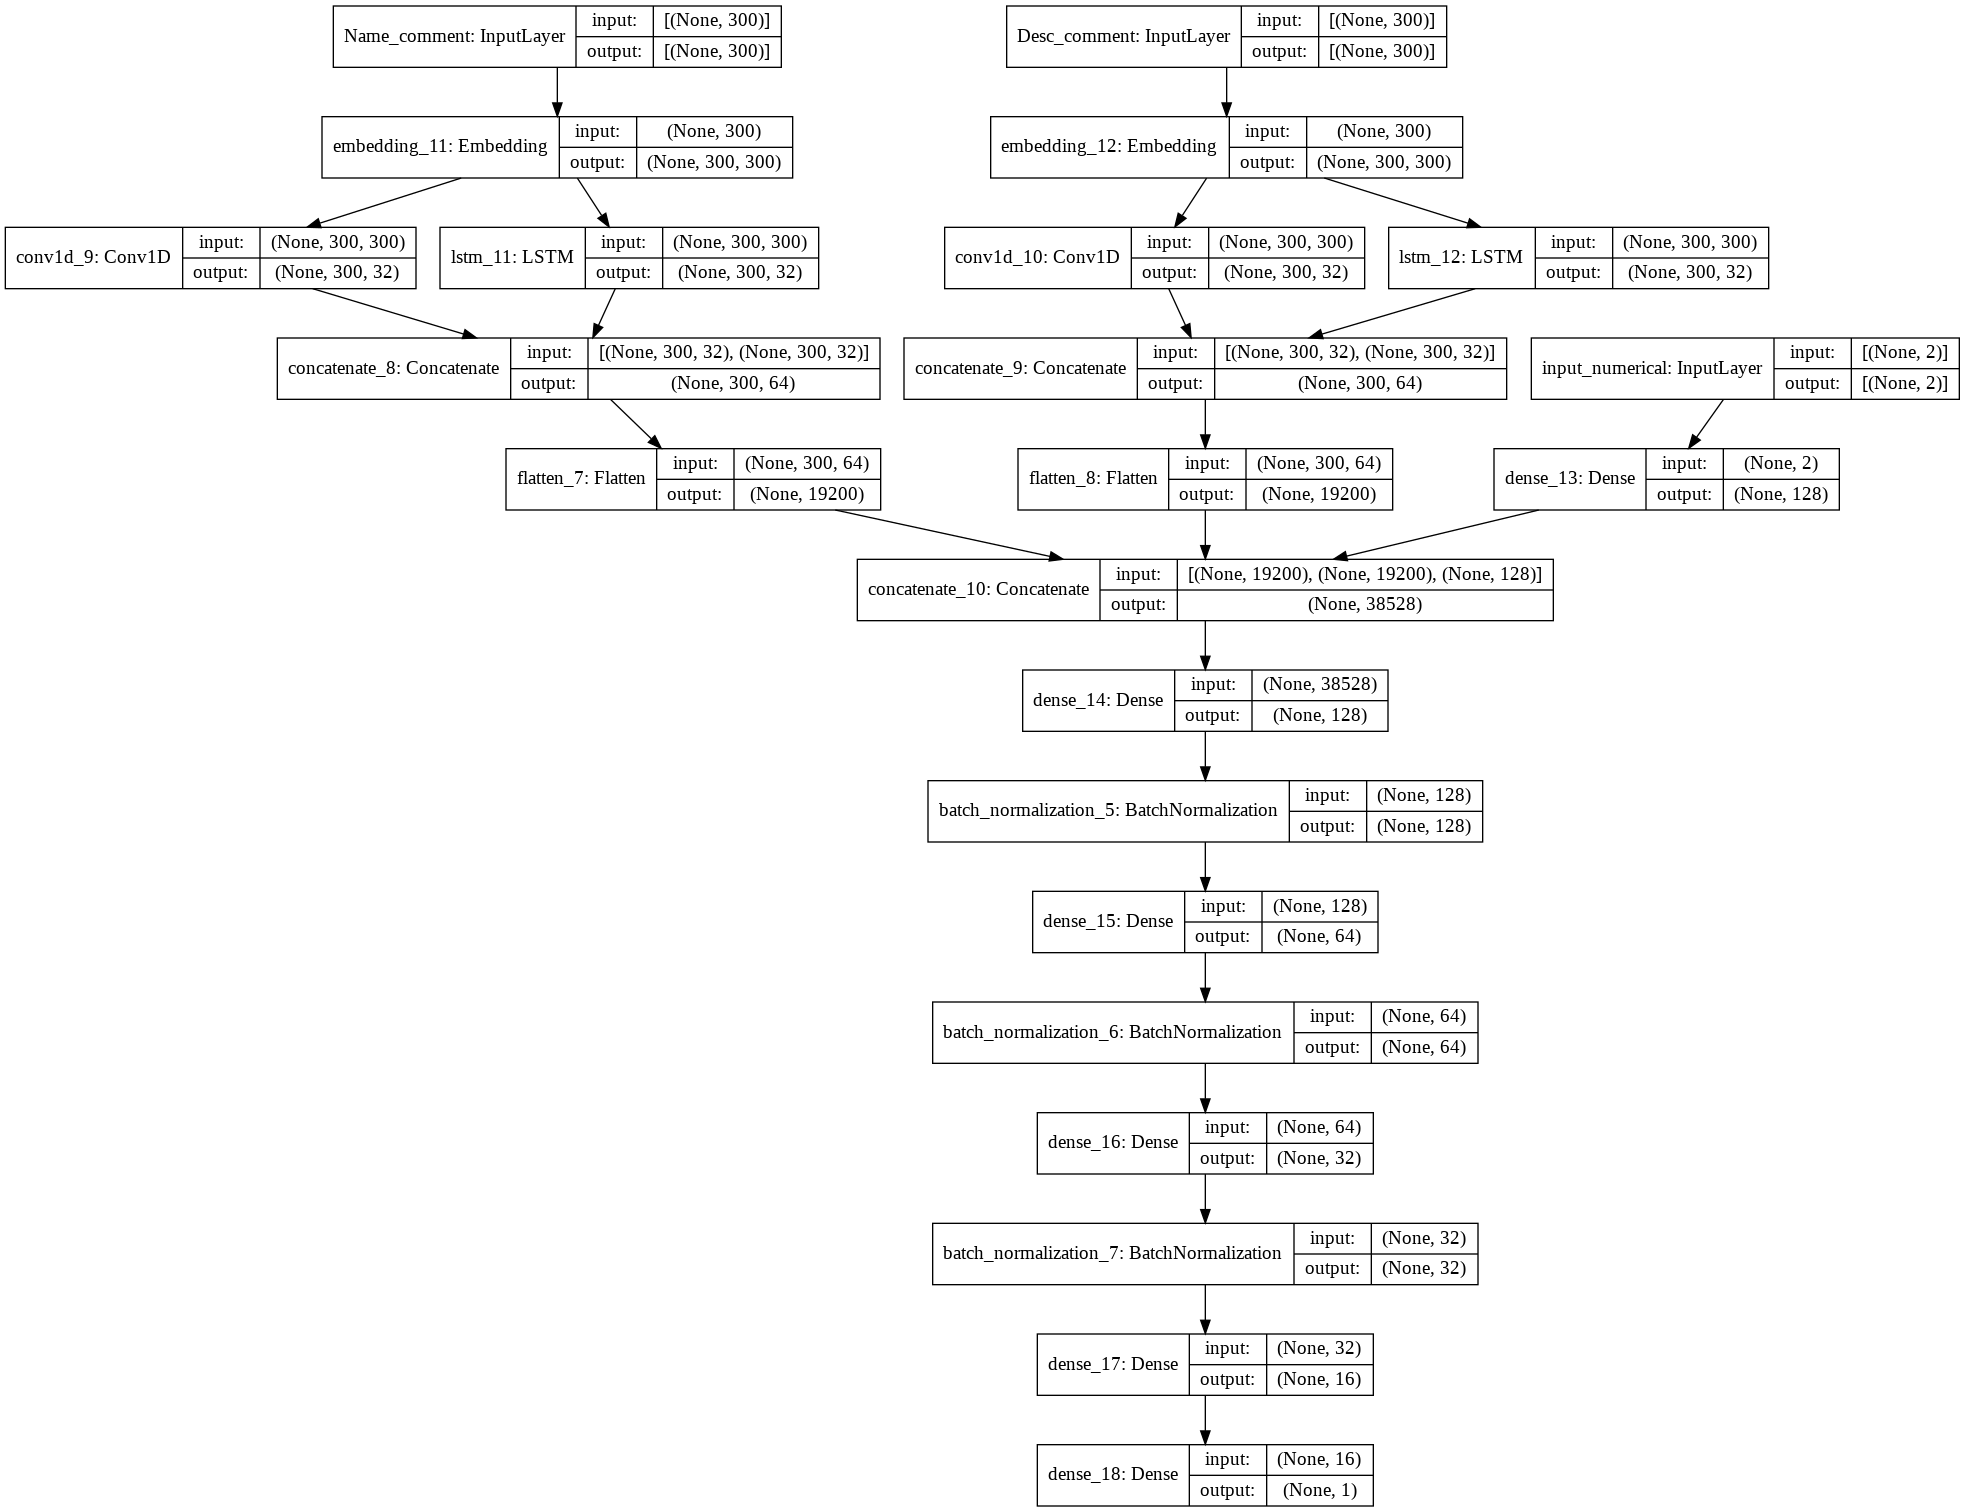

In [ ]:
plot_model(model1, to_file='model_1.png', show_shapes=True, show_layer_names=True)

In [ ]:
from tensorflow.keras.callbacks import *
filepath="weights_1.best.hdf1"
checkpoint = ModelCheckpoint(filepath, monitor='val_root_mean_squared_log_error', verbose=1, mode='min')
earlystop = EarlyStopping(monitor = 'val_root_mean_squared_log_error',  mode="min",min_delta = 0, patience = 3,verbose = 1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_root_mean_squared_log_error', factor = 0.25, patience = 2, verbose = 1)
%reload_ext tensorboard
import datetime
logdir = os.path.join("logs_1", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
#tensorboard = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
tensorboard = TensorBoard(log_dir=logdir, histogram_freq=0, write_graph=True, write_grads=False, write_images=False)
callbacks = [checkpoint,reduce_lr,tensorboard]

In [ ]:
history_1 =model1.fit(x=X_train, y=y_train,epochs=20,verbose=1,callbacks=callbacks,batch_size=512,validation_data=(X_test, y_test))

Epoch 1/20
1915/1915 [==============================] - 212s 111ms/step - loss: 0.2792 - root_mean_squared_error: 0.5284 - root_mean_squared_log_error: 0.5266 - val_loss: 0.2374 - val_root_mean_squared_error: 0.4872 - val_root_mean_squared_log_error: 0.4868

Epoch 00001: saving model to weights_1.best.hdf1


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


Epoch 2/20
1915/1915 [==============================] - 209s 109ms/step - loss: 0.2255 - root_mean_squared_error: 0.4749 - root_mean_squared_log_error: 0.4744 - val_loss: 0.2270 - val_root_mean_squared_error: 0.4764 - val_root_mean_squared_log_error: 0.4760

Epoch 00002: saving model to weights_1.best.hdf1


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


Epoch 3/20
1915/1915 [==============================] - 209s 109ms/step - loss: 0.2085 - root_mean_squared_error: 0.4566 - root_mean_squared_log_error: 0.4562 - val_loss: 0.2144 - val_root_mean_squared_error: 0.4631 - val_root_mean_squared_log_error: 0.4626

Epoch 00003: saving model to weights_1.best.hdf1


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


Epoch 4/20
1915/1915 [==============================] - 208s 109ms/step - loss: 0.1970 - root_mean_squared_error: 0.4439 - root_mean_squared_log_error: 0.4434 - val_loss: 0.2064 - val_root_mean_squared_error: 0.4543 - val_root_mean_squared_log_error: 0.4539

Epoch 00004: saving model to weights_1.best.hdf1


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


Epoch 5/20
1915/1915 [==============================] - 209s 109ms/step - loss: 0.1892 - root_mean_squared_error: 0.4350 - root_mean_squared_log_error: 0.4345 - val_loss: 0.2175 - val_root_mean_squared_error: 0.4664 - val_root_mean_squared_log_error: 0.4659

Epoch 00005: saving model to weights_1.best.hdf1


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


Epoch 6/20
1915/1915 [==============================] - 210s 109ms/step - loss: 0.1821 - root_mean_squared_error: 0.4267 - root_mean_squared_log_error: 0.4263 - val_loss: 0.1971 - val_root_mean_squared_error: 0.4440 - val_root_mean_squared_log_error: 0.4435

Epoch 00006: saving model to weights_1.best.hdf1


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


Epoch 7/20
1915/1915 [==============================] - 211s 110ms/step - loss: 0.1761 - root_mean_squared_error: 0.4197 - root_mean_squared_log_error: 0.4193 - val_loss: 0.1976 - val_root_mean_squared_error: 0.4445 - val_root_mean_squared_log_error: 0.4441

Epoch 00007: saving model to weights_1.best.hdf1


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


Epoch 8/20
1915/1915 [==============================] - 211s 110ms/step - loss: 0.1705 - root_mean_squared_error: 0.4129 - root_mean_squared_log_error: 0.4125 - val_loss: 0.1992 - val_root_mean_squared_error: 0.4464 - val_root_mean_squared_log_error: 0.4459

Epoch 00008: saving model to weights_1.best.hdf1


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


Epoch 9/20
1915/1915 [==============================] - 212s 111ms/step - loss: 0.1657 - root_mean_squared_error: 0.4070 - root_mean_squared_log_error: 0.4066 - val_loss: 0.1970 - val_root_mean_squared_error: 0.4439 - val_root_mean_squared_log_error: 0.4434

Epoch 00009: saving model to weights_1.best.hdf1


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


Epoch 10/20
1915/1915 [==============================] - 210s 109ms/step - loss: 0.1612 - root_mean_squared_error: 0.4016 - root_mean_squared_log_error: 0.4012 - val_loss: 0.1983 - val_root_mean_squared_error: 0.4454 - val_root_mean_squared_log_error: 0.4449

Epoch 00010: saving model to weights_1.best.hdf1


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


Epoch 11/20
1915/1915 [==============================] - 209s 109ms/step - loss: 0.1571 - root_mean_squared_error: 0.3963 - root_mean_squared_log_error: 0.3960 - val_loss: 0.1963 - val_root_mean_squared_error: 0.4431 - val_root_mean_squared_log_error: 0.4427

Epoch 00011: saving model to weights_1.best.hdf1


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


Epoch 12/20
1915/1915 [==============================] - 208s 109ms/step - loss: 0.1533 - root_mean_squared_error: 0.3916 - root_mean_squared_log_error: 0.3912 - val_loss: 0.2011 - val_root_mean_squared_error: 0.4485 - val_root_mean_squared_log_error: 0.4480

Epoch 00012: saving model to weights_1.best.hdf1


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


Epoch 13/20
1915/1915 [==============================] - 208s 109ms/step - loss: 0.1499 - root_mean_squared_error: 0.3872 - root_mean_squared_log_error: 0.3869 - val_loss: 0.1987 - val_root_mean_squared_error: 0.4457 - val_root_mean_squared_log_error: 0.4452

Epoch 00013: saving model to weights_1.best.hdf1


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


Epoch 14/20
1915/1915 [==============================] - 208s 109ms/step - loss: 0.1466 - root_mean_squared_error: 0.3829 - root_mean_squared_log_error: 0.3825 - val_loss: 0.2005 - val_root_mean_squared_error: 0.4478 - val_root_mean_squared_log_error: 0.4473

Epoch 00014: saving model to weights_1.best.hdf1


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


Epoch 15/20
1915/1915 [==============================] - 208s 109ms/step - loss: 0.1439 - root_mean_squared_error: 0.3794 - root_mean_squared_log_error: 0.3790 - val_loss: 0.2004 - val_root_mean_squared_error: 0.4477 - val_root_mean_squared_log_error: 0.4472

Epoch 00015: saving model to weights_1.best.hdf1


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


Epoch 16/20
1915/1915 [==============================] - 209s 109ms/step - loss: 0.1412 - root_mean_squared_error: 0.3757 - root_mean_squared_log_error: 0.3754 - val_loss: 0.2035 - val_root_mean_squared_error: 0.4511 - val_root_mean_squared_log_error: 0.4506

Epoch 00016: saving model to weights_1.best.hdf1


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


Epoch 17/20
1915/1915 [==============================] - 211s 110ms/step - loss: 0.1385 - root_mean_squared_error: 0.3722 - root_mean_squared_log_error: 0.3719 - val_loss: 0.2009 - val_root_mean_squared_error: 0.4482 - val_root_mean_squared_log_error: 0.4478

Epoch 00017: saving model to weights_1.best.hdf1


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


Epoch 18/20
1915/1915 [==============================] - 213s 111ms/step - loss: 0.1362 - root_mean_squared_error: 0.3690 - root_mean_squared_log_error: 0.3687 - val_loss: 0.2007 - val_root_mean_squared_error: 0.4480 - val_root_mean_squared_log_error: 0.4476

Epoch 00018: saving model to weights_1.best.hdf1


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


Epoch 19/20
1915/1915 [==============================] - 212s 111ms/step - loss: 0.1338 - root_mean_squared_error: 0.3657 - root_mean_squared_log_error: 0.3654 - val_loss: 0.2029 - val_root_mean_squared_error: 0.4504 - val_root_mean_squared_log_error: 0.4500

Epoch 00019: saving model to weights_1.best.hdf1


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


Epoch 20/20
1915/1915 [==============================] - 221s 115ms/step - loss: 0.1320 - root_mean_squared_error: 0.3633 - root_mean_squared_log_error: 0.3629 - val_loss: 0.2044 - val_root_mean_squared_error: 0.4521 - val_root_mean_squared_log_error: 0.4516

Epoch 00020: saving model to weights_1.best.hdf1


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


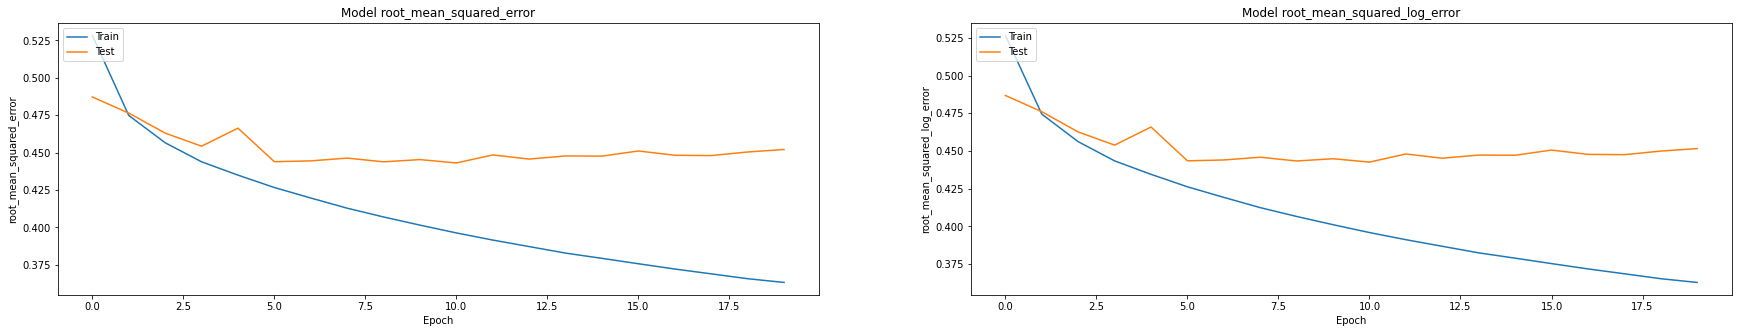

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(30, 5))
plt.subplot(121)
plt.plot(history_1.history['root_mean_squared_error'])
plt.plot(history_1.history['val_root_mean_squared_error'])
plt.title('Model root_mean_squared_error')
plt.ylabel('root_mean_squared_error')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation f1_score
plt.subplot(122)
plt.plot(history_1.history['root_mean_squared_log_error'])
plt.plot(history_1.history['val_root_mean_squared_log_error'])
plt.title('Model root_mean_squared_log_error')
plt.ylabel('root_mean_squared_log_error')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
model_1_pred=model1.predict(test_f)

In [ ]:
submission=pd.read_csv('/content/gdrive/MyDrive/mercari/sample_submission_stg2.csv')
submission.head()

,test_id,price
0,0,26.738
1,1,26.738
2,2,26.738
3,3,26.738
4,4,26.738


In [ ]:
final_pred_1=np.expm1(model_1_pred)

In [ ]:
model_1_pred=model1.predict(test_f)
submission=pd.read_csv('/content/gdrive/MyDrive/mercari/sample_submission_stg2.csv')
final_pred_1=np.expm1(model_1_pred)
submission['price']=final_pred_1
submission.to_csv('DL_1_submission.csv',index=False)

In [ ]:
submission.to_csv('DL_1_submission.csv',index=False)

In [ ]:
def Deep_CNN1D21(Name_len,token_name,embedding_name,item_len,token_desc,embedding_desc):
    drop_lstm = 0.25
    drop_dense = 0.25
    num_lstm=150
    input_1 = Input(shape=(Name_len,),name = 'Name_comment')
    embedding_layer_1 = Embedding(len(token_name.word_index) + 1,300,weights=[embedding_name],input_length=Name_len,trainable=False,dtype=tf.float32)(input_1)
    conv_1_1 = Conv1D(32,3,strides=1, padding='same',activation='relu')(embedding_layer_1)
    lstm_1_1 = LSTM(32,dropout=drop_lstm,return_sequences=True,dtype=tf.float32)(embedding_layer_1)
    conv_1_3 = Conv1D(8,3, strides=1, padding='same',activation='relu')(embedding_layer_1)
    concate_1 = keras.layers.Concatenate(axis=-1)([conv_1_1, lstm_1_1, conv_1_3])
    pool_1 = keras.layers.MaxPooling1D(pool_size=2, strides=2, padding='same')(concate_1)
    conv_2_1 = keras.layers.Conv1D(8,7, strides=1, padding='same',activation='relu')(pool_1)
    lstm_2_1 =  LSTM(32,dropout=drop_lstm,return_sequences=True,dtype=tf.float32)(pool_1) 
    conv_2_3 = keras.layers.Conv1D(32,3, strides=1, padding='same',activation='relu')(pool_1)
    concate_2 = keras.layers.Concatenate(axis=-1)([conv_2_1, lstm_2_1, conv_2_3])
    pool_2 = keras.layers.MaxPooling1D(pool_size=2, strides=2, padding='same')(concate_2)
    conv_3 = Conv1D(20,3,strides=2, padding='same')(pool_2)
    flatten_1 = Flatten()(conv_3)

    # creating layers for parent comment data
    input_2 = Input(shape=(item_len,),name = 'item_comment')
    embedding_layer_2 = Embedding(len(token_desc.word_index) + 1,300,weights=[embedding_desc],input_length=item_len,trainable=False,dtype=tf.float32)(input_2)
    conv_1_1 = Conv1D(32,3,strides=1, padding='same',activation='relu')(embedding_layer_2)
    lstm_1_2 = LSTM(32,dropout=drop_lstm,return_sequences=True,dtype=tf.float32)(embedding_layer_2)
    conv_1_3 = Conv1D(8,3, strides=1, padding='same',activation='relu')(embedding_layer_2)
    concate_1 = keras.layers.Concatenate(axis=-1)([conv_1_1, lstm_1_2, conv_1_3])
    pool_1 = keras.layers.MaxPooling1D(pool_size=2, strides=2, padding='same')(concate_1)
    conv_2_1 = keras.layers.Conv1D(8,7, strides=1, padding='same',activation='relu')(pool_1)
    lstm_2_2 =  LSTM(32,dropout=drop_lstm,return_sequences=True,dtype=tf.float32)(pool_1) 
    conv_2_3 = keras.layers.Conv1D(32,3, strides=1, padding='same',activation='relu')(pool_1)
    concate_2 = keras.layers.Concatenate(axis=-1)([conv_2_1, lstm_2_2, conv_2_3])
    pool_2 = keras.layers.MaxPooling1D(pool_size=2, strides=2, padding='same')(concate_2)
    conv_131 = Conv1D(20,3,strides=2, padding='same')(pool_2)
    flatten_2 = Flatten()(conv_131)

    # creating layers for numerical columns
    input_3 = Input(shape=(2,), name = "input_numerical")
    dense_num_layer = Dense(128, activation = "relu")(input_3)

    concatenated_layer = keras.layers.concatenate([flatten_1,flatten_2,dense_num_layer],axis=-1)

    # creating further layers
    y = Dense(2048,activation='relu',kernel_initializer=he_normal(),kernel_regularizer=l2(0.01))(concatenated_layer)
    y = BatchNormalization()(y)
    y=Dropout(0.60)(y)
    y = Dense(1024,activation='relu',kernel_initializer=he_normal(),kernel_regularizer=l2(0.01))(y)
    y = BatchNormalization()(y)
    y=Dropout(0.40)(y)
    y = Dense(512,activation='relu',kernel_initializer=he_normal(),kernel_regularizer=l2(0.01))(y)
    y = BatchNormalization()(y)
    y=Dropout(0.30)(y)
    y = Dense(128,activation='relu',kernel_initializer=he_normal(),kernel_regularizer=l2(0.01))(y)
    y = BatchNormalization()(y)
    y=Dropout(0.20)(y)
    
    output = Dense(1)(y)
    model = Model(inputs = [input_1,input_2,input_3], outputs = [output])
    return model

In [ ]:
model2=Deep_CNN1D21(Name_len,token_name,embedding_name,item_len,token_desc,embedding_desc)
model2.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Name_comment (InputLayer)       [(None, 300)]        0                                            
__________________________________________________________________________________________________
item_comment (InputLayer)       [(None, 300)]        0                                            
__________________________________________________________________________________________________
embedding_14 (Embedding)        (None, 300, 300)     25171500    Name_comment[0][0]               
__________________________________________________________________________________________________
embedding_15 (Embedding)        (None, 300, 300)     38772600    item_comment[0][0]               
____________________________________________________________________________________________

In [ ]:
model2.compile(optimizer='adam', loss='mean_squared_error',metrics=[tf.keras.metrics.RootMeanSquaredError(),root_mean_squared_log_error])

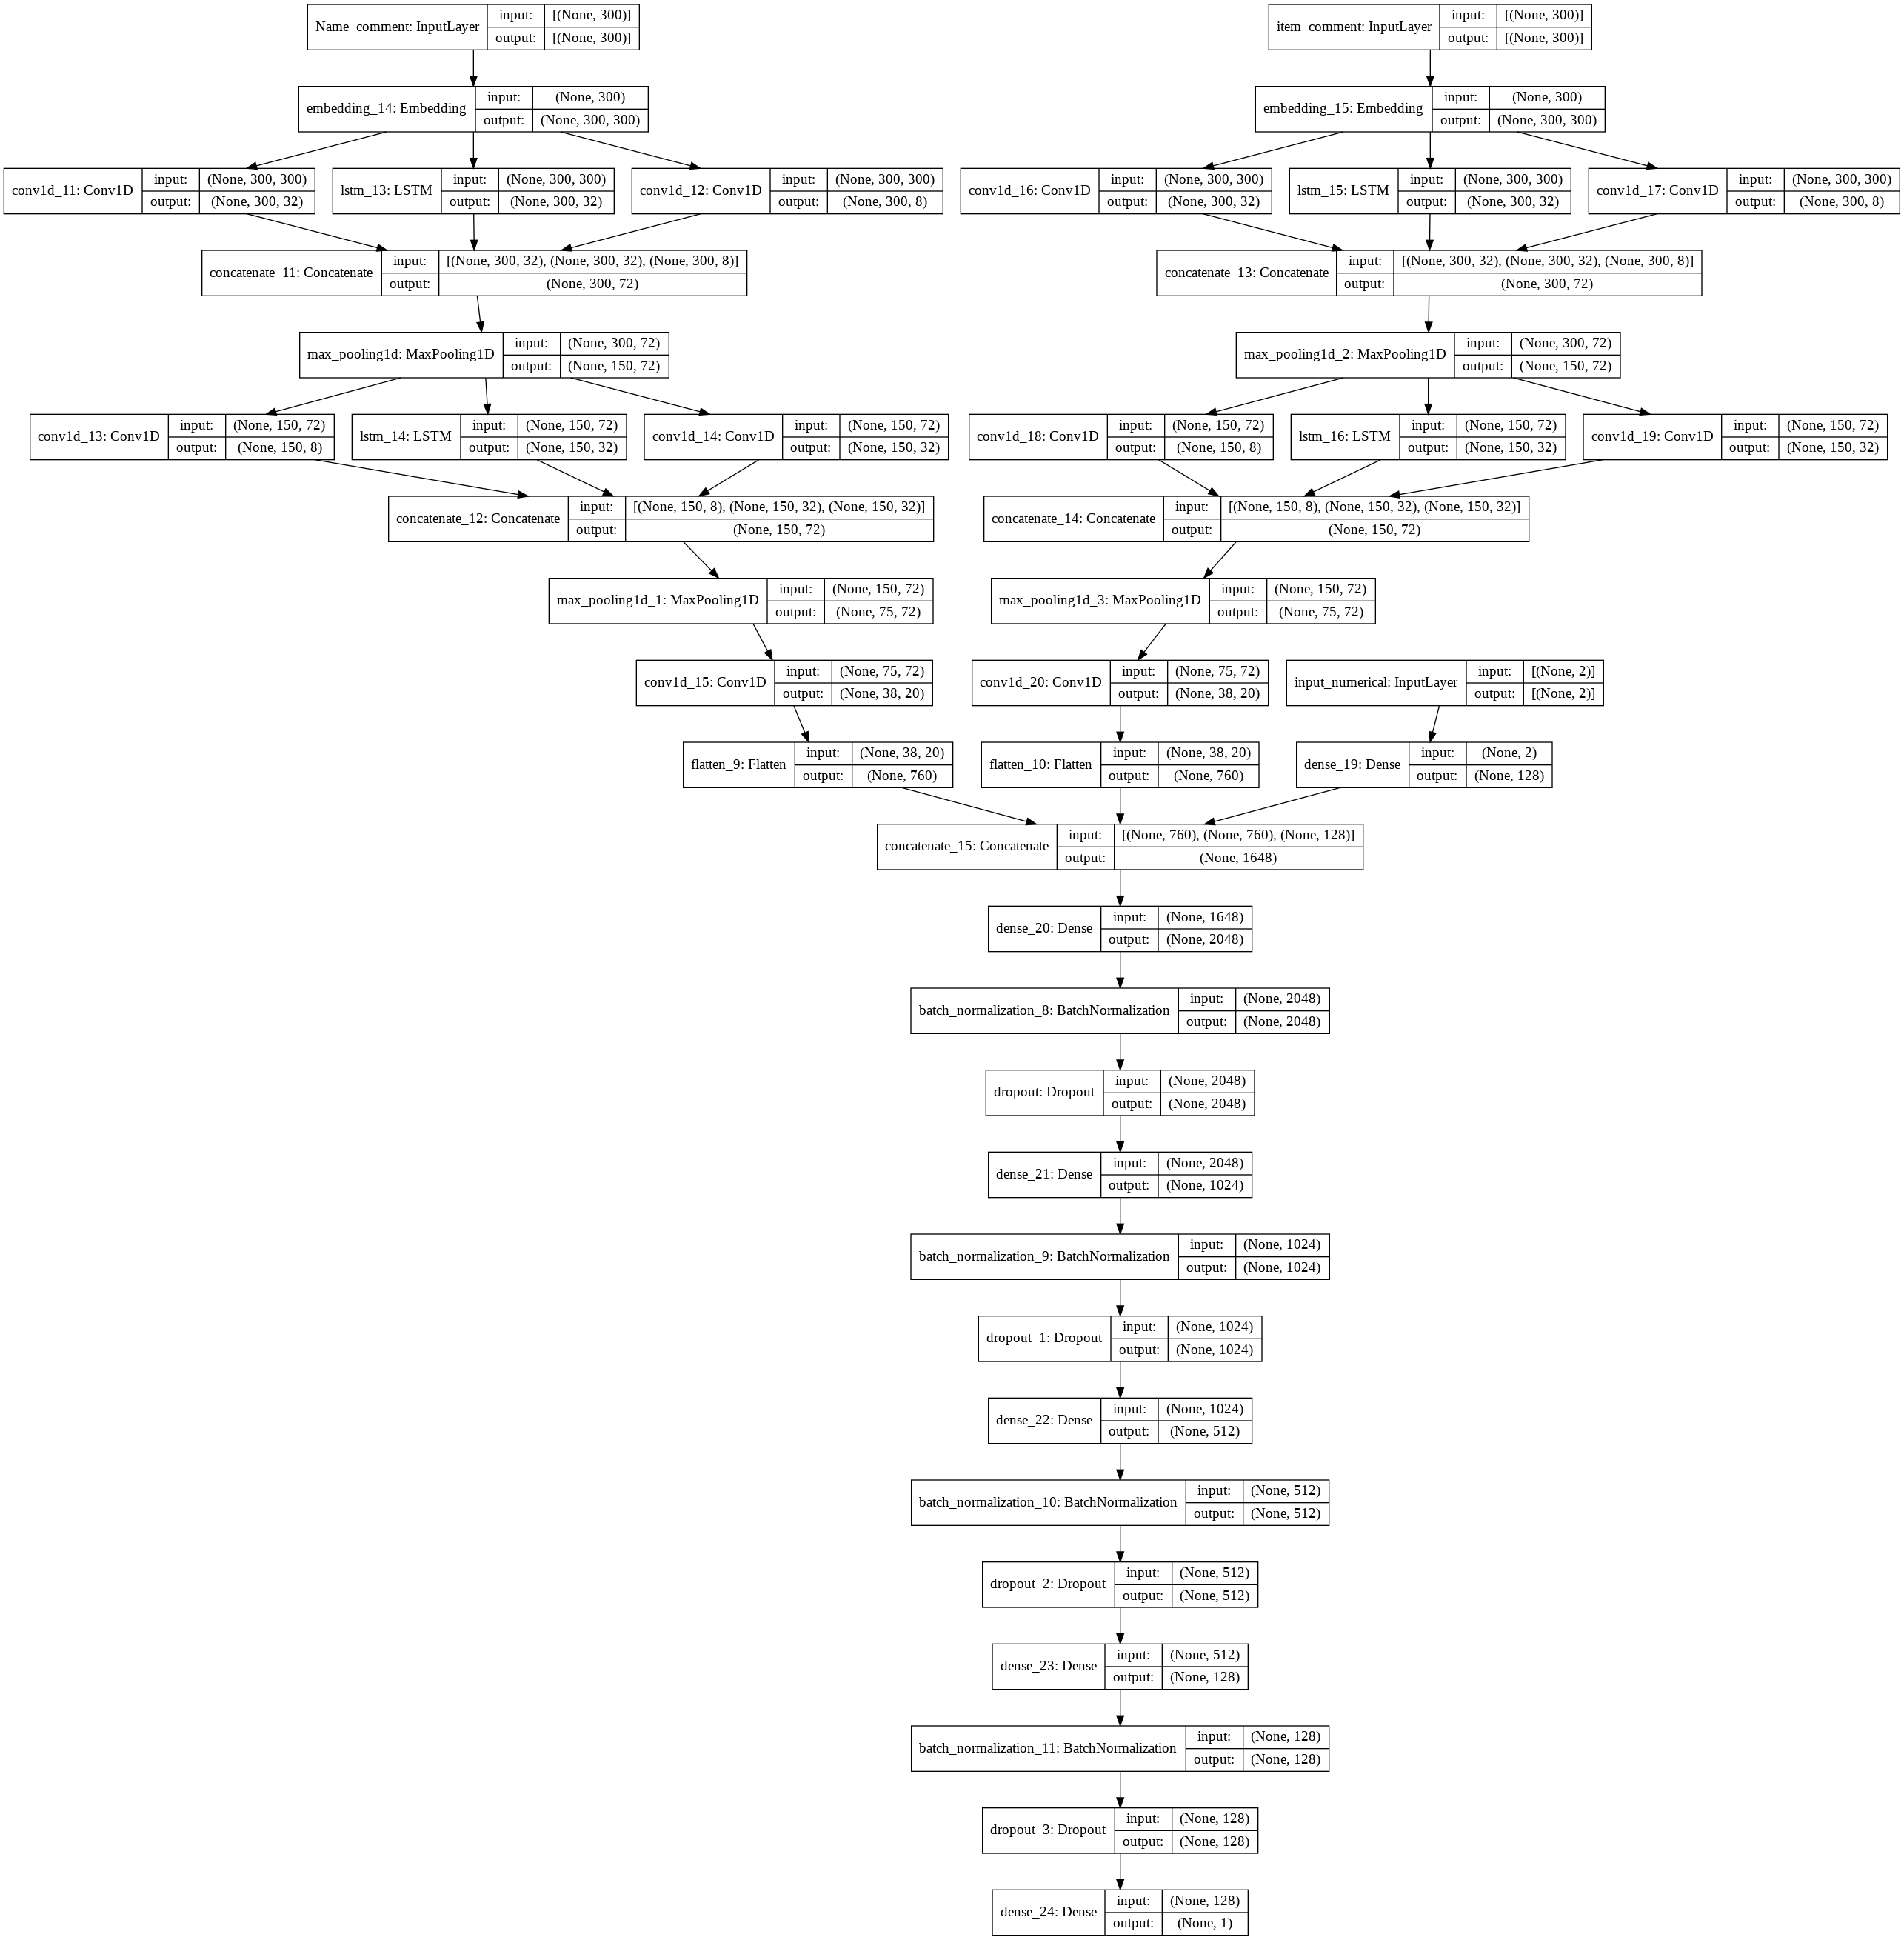

In [ ]:
plot_model(model2, to_file='model_1.png', show_shapes=True, show_layer_names=True)

In [ ]:
from tensorflow.keras.callbacks import *
filepath="weights_1.best.hdf1"
checkpoint = ModelCheckpoint(filepath, monitor='val_root_mean_squared_log_error', verbose=1, mode='min')
earlystop = EarlyStopping(monitor = 'val_root_mean_squared_log_error',  mode="min",min_delta = 0, patience = 3,verbose = 1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_root_mean_squared_log_error', factor = 0.25, patience = 2, verbose = 1)
%reload_ext tensorboard
import datetime
logdir = os.path.join("logs_1", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
#tensorboard = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
tensorboard = TensorBoard(log_dir=logdir, histogram_freq=0, write_graph=True, write_grads=False, write_images=False)
callbacks = [checkpoint,reduce_lr,tensorboard]

In [ ]:
history_1 =model2.fit(x=X_train, y=y_train,epochs=20,verbose=1,callbacks=callbacks,batch_size=512,validation_data=(X_test, y_test))

Epoch 1/20
1915/1915 [==============================] - 376s 192ms/step - loss: 4.9564 - root_mean_squared_error: 0.9653 - root_mean_squared_log_error: 0.8547 - val_loss: 5.0747 - val_root_mean_squared_error: 2.1337 - val_root_mean_squared_log_error: 2.1072

Epoch 00001: saving model to weights_1.best.hdf1


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


Epoch 2/20
1915/1915 [==============================] - 364s 190ms/step - loss: 0.5350 - root_mean_squared_error: 0.5678 - root_mean_squared_log_error: 0.5659 - val_loss: 0.5825 - val_root_mean_squared_error: 0.5333 - val_root_mean_squared_log_error: 0.5328

Epoch 00002: saving model to weights_1.best.hdf1


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


Epoch 3/20
1915/1915 [==============================] - 366s 191ms/step - loss: 0.3936 - root_mean_squared_error: 0.5171 - root_mean_squared_log_error: 0.5163 - val_loss: 0.3320 - val_root_mean_squared_error: 0.5000 - val_root_mean_squared_log_error: 0.4996

Epoch 00003: saving model to weights_1.best.hdf1


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


Epoch 4/20
1915/1915 [==============================] - 365s 190ms/step - loss: 0.3003 - root_mean_squared_error: 0.4826 - root_mean_squared_log_error: 0.4822 - val_loss: 0.3060 - val_root_mean_squared_error: 0.4986 - val_root_mean_squared_log_error: 0.4981

Epoch 00004: saving model to weights_1.best.hdf1


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


Epoch 5/20
1915/1915 [==============================] - 363s 189ms/step - loss: 0.2767 - root_mean_squared_error: 0.4648 - root_mean_squared_log_error: 0.4644 - val_loss: 0.4037 - val_root_mean_squared_error: 0.5828 - val_root_mean_squared_log_error: 0.5824

Epoch 00005: saving model to weights_1.best.hdf1


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


Epoch 6/20
1915/1915 [==============================] - 363s 190ms/step - loss: 0.2651 - root_mean_squared_error: 0.4543 - root_mean_squared_log_error: 0.4539 - val_loss: 0.3267 - val_root_mean_squared_error: 0.5172 - val_root_mean_squared_log_error: 0.5169

Epoch 00006: saving model to weights_1.best.hdf1


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets



Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Epoch 7/20
1915/1915 [==============================] - 364s 190ms/step - loss: 0.2057 - root_mean_squared_error: 0.4341 - root_mean_squared_log_error: 0.4337 - val_loss: 0.2271 - val_root_mean_squared_error: 0.4583 - val_root_mean_squared_log_error: 0.4578

Epoch 00007: saving model to weights_1.best.hdf1


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


Epoch 8/20
1915/1915 [==============================] - 364s 190ms/step - loss: 0.2000 - root_mean_squared_error: 0.4291 - root_mean_squared_log_error: 0.4287 - val_loss: 0.2198 - val_root_mean_squared_error: 0.4504 - val_root_mean_squared_log_error: 0.4499

Epoch 00008: saving model to weights_1.best.hdf1


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


Epoch 9/20
1915/1915 [==============================] - 362s 189ms/step - loss: 0.1973 - root_mean_squared_error: 0.4261 - root_mean_squared_log_error: 0.4257 - val_loss: 0.2332 - val_root_mean_squared_error: 0.4667 - val_root_mean_squared_log_error: 0.4662

Epoch 00009: saving model to weights_1.best.hdf1


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


Epoch 10/20
1915/1915 [==============================] - 362s 189ms/step - loss: 0.1947 - root_mean_squared_error: 0.4233 - root_mean_squared_log_error: 0.4229 - val_loss: 0.2114 - val_root_mean_squared_error: 0.4422 - val_root_mean_squared_log_error: 0.4417

Epoch 00010: saving model to weights_1.best.hdf1


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


Epoch 11/20
1915/1915 [==============================] - 363s 189ms/step - loss: 0.1926 - root_mean_squared_error: 0.4211 - root_mean_squared_log_error: 0.4208 - val_loss: 0.2261 - val_root_mean_squared_error: 0.4600 - val_root_mean_squared_log_error: 0.4596

Epoch 00011: saving model to weights_1.best.hdf1


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


Epoch 12/20
1915/1915 [==============================] - 363s 190ms/step - loss: 0.1907 - root_mean_squared_error: 0.4189 - root_mean_squared_log_error: 0.4185 - val_loss: 0.2258 - val_root_mean_squared_error: 0.4595 - val_root_mean_squared_log_error: 0.4590

Epoch 00012: saving model to weights_1.best.hdf1


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets



Epoch 00012: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
Epoch 13/20
1915/1915 [==============================] - 362s 189ms/step - loss: 0.1746 - root_mean_squared_error: 0.4105 - root_mean_squared_log_error: 0.4101 - val_loss: 0.1992 - val_root_mean_squared_error: 0.4404 - val_root_mean_squared_log_error: 0.4399

Epoch 00013: saving model to weights_1.best.hdf1


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


Epoch 14/20
1915/1915 [==============================] - 361s 189ms/step - loss: 0.1726 - root_mean_squared_error: 0.4092 - root_mean_squared_log_error: 0.4088 - val_loss: 0.2035 - val_root_mean_squared_error: 0.4455 - val_root_mean_squared_log_error: 0.4451

Epoch 00014: saving model to weights_1.best.hdf1


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


Epoch 15/20
1915/1915 [==============================] - 363s 190ms/step - loss: 0.1720 - root_mean_squared_error: 0.4085 - root_mean_squared_log_error: 0.4082 - val_loss: 0.2052 - val_root_mean_squared_error: 0.4471 - val_root_mean_squared_log_error: 0.4467

Epoch 00015: saving model to weights_1.best.hdf1


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets



Epoch 00015: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.
Epoch 16/20
1915/1915 [==============================] - 365s 190ms/step - loss: 0.1675 - root_mean_squared_error: 0.4053 - root_mean_squared_log_error: 0.4049 - val_loss: 0.1938 - val_root_mean_squared_error: 0.4372 - val_root_mean_squared_log_error: 0.4368

Epoch 00016: saving model to weights_1.best.hdf1


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


Epoch 17/20
1915/1915 [==============================] - 362s 189ms/step - loss: 0.1664 - root_mean_squared_error: 0.4049 - root_mean_squared_log_error: 0.4045 - val_loss: 0.1945 - val_root_mean_squared_error: 0.4383 - val_root_mean_squared_log_error: 0.4379

Epoch 00017: saving model to weights_1.best.hdf1


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


Epoch 18/20
1915/1915 [==============================] - 364s 190ms/step - loss: 0.1659 - root_mean_squared_error: 0.4045 - root_mean_squared_log_error: 0.4041 - val_loss: 0.1940 - val_root_mean_squared_error: 0.4378 - val_root_mean_squared_log_error: 0.4373

Epoch 00018: saving model to weights_1.best.hdf1


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets



Epoch 00018: ReduceLROnPlateau reducing learning rate to 3.906250185536919e-06.
Epoch 19/20
1915/1915 [==============================] - 363s 190ms/step - loss: 0.1648 - root_mean_squared_error: 0.4035 - root_mean_squared_log_error: 0.4032 - val_loss: 0.1928 - val_root_mean_squared_error: 0.4370 - val_root_mean_squared_log_error: 0.4366

Epoch 00019: saving model to weights_1.best.hdf1


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


Epoch 20/20
1915/1915 [==============================] - 362s 189ms/step - loss: 0.1643 - root_mean_squared_error: 0.4032 - root_mean_squared_log_error: 0.4028 - val_loss: 0.1928 - val_root_mean_squared_error: 0.4372 - val_root_mean_squared_log_error: 0.4368

Epoch 00020: saving model to weights_1.best.hdf1


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


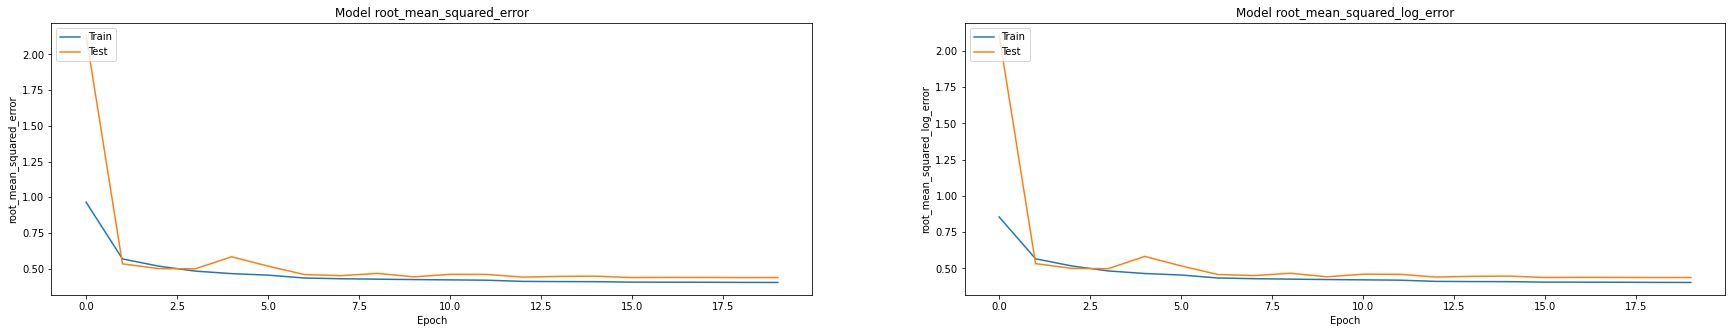

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(30, 5))
plt.subplot(121)
plt.plot(history_1.history['root_mean_squared_error'])
plt.plot(history_1.history['val_root_mean_squared_error'])
plt.title('Model root_mean_squared_error')
plt.ylabel('root_mean_squared_error')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation f1_score
plt.subplot(122)
plt.plot(history_1.history['root_mean_squared_log_error'])
plt.plot(history_1.history['val_root_mean_squared_log_error'])
plt.title('Model root_mean_squared_log_error')
plt.ylabel('root_mean_squared_log_error')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
model_1_pred=model2.predict(test_f)
submission=pd.read_csv('/content/gdrive/MyDrive/mercari/sample_submission_stg2.csv')
final_pred_1=np.expm1(model_1_pred)
submission['price']=final_pred_1
submission.to_csv('/content/gdrive/MyDrive/mercari/DL_1_submission.csv',index=False)

In [ ]:
submission.to_csv('/content/gdrive/MyDrive/mercari/DL_1_submission.csv',index=False)